In [7]:
# Cell 1 — imports and setup
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')

# create folders for outputs
Path("eda_outputs").mkdir(parents=True, exist_ok=True)


In [21]:
# Cell 2 — load data
DATA_PATH = Path("data/cleaned_engineered_data_small.csv")


if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Place your file at this path.")

df = pd.read_csv(DATA_PATH, parse_dates=['Date'], infer_datetime_format=True)
print("Loaded rows:", len(df))
print("\nColumns:\n", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
display(df.head())


Loaded rows: 10000

Columns:
 ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'IsHoliday', 'Month', 'Week', 'Year', 'Day', 'DayOfWeek', 'Weekly_Sales_Rolling4', 'Sales_vs_StoreMean', 'Type_B', 'Type_C']

Dtypes:
 Store                             int64
Dept                              int64
Date                     datetime64[ns]
Weekly_Sales                    float64
Temperature                     float64
Fuel_Price                      float64
MarkDown1                       float64
MarkDown2                       float64
MarkDown3                       float64
MarkDown4                       float64
MarkDown5                       float64
CPI                             float64
Unemployment                    float64
Size                              int64
IsHoliday                         int64
Month                             int64
Week                        

C:\Users\User\AppData\Local\Temp\ipykernel_14324\241718703.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(DATA_PATH, parse_dates=['Date'], infer_datetime_format=True)


,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,IsHoliday,Month,Week,Year,Day,DayOfWeek,Weekly_Sales_Rolling4,Sales_vs_StoreMean,Type_B,Type_C
0,1,1,2010-02-05,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,0,2,5,2010,5,4,NaN,1.338132,False,False
1,1,1,2010-02-12,46039.49,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,1,2,6,2010,12,4,NaN,2.471742,False,False
2,1,1,2010-02-19,41595.55,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,0,2,7,2010,19,4,NaN,2.233158,False,False
3,1,1,2010-02-26,19403.54,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,0,2,8,2010,26,4,32990.77,1.041726,False,False
4,1,1,2010-03-05,21827.90,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,0,3,9,2010,5,4,32216.62,1.171884,False,False


In [9]:
# Cell 3 — basic cleaning checks
# Trim whitespace from column names
df.columns = [c.strip() for c in df.columns]

# Lowercase boolean-like columns if necessary (optional)
# Example: if Type_B / Type_C are strings 'True'/'False', convert:
for col in ['Type_B', 'Type_C', 'IsHoliday']:
    if col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].replace({'TRUE':True,'True':True,'FALSE':False,'False':False, '0':False, '1':True})
        if df[col].dtype == bool:
            df[col] = df[col].astype(int)  # convert boolean to 0/1 for EDA convenience

# Ensure Date column parsed
if df['Date'].dtype == object:
    try:
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception as e:
        print("Warning: Date parsing failed:", e)

print("After normalization dtypes:\n", df.dtypes)


After normalization dtypes:
 Store                             int64
Dept                              int64
Date                     datetime64[ns]
Weekly_Sales                    float64
Temperature                     float64
Fuel_Price                      float64
MarkDown1                       float64
MarkDown2                       float64
MarkDown3                       float64
MarkDown4                       float64
MarkDown5                       float64
CPI                             float64
Unemployment                    float64
Size                              int64
IsHoliday                         int64
Month                             int64
Week                              int64
Year                              int64
Day                               int64
DayOfWeek                         int64
Weekly_Sales_Rolling4           float64
Sales_vs_StoreMean              float64
Type_B                            int64
Type_C                            int64
dtype: obje

In [23]:
# Convert bools to 0/1
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)


In [10]:
# Cell 4 — missing value analysis
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Columns with missing values (count):")
print(missing)

# Common strategy suggestions:
# - Markdown columns: fill with 0 (they indicate promotional markdowns)
# - Lags/rolling: if present, either drop rows with NaNs for training or impute group medians
# - For EDA keep missing as-is except for plots that don't accept NaN

# Fill Markdown columns with 0 if they exist
markdown_cols = [c for c in ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'] if c in df.columns]
if markdown_cols:
    df[markdown_cols] = df[markdown_cols].fillna(0)
    print("Filled markdown cols with 0:", markdown_cols)

# Example: for a few numeric columns with few NaNs, fill with median (use case-specific)
few_na_cols = [c for c in df.columns if df[c].isna().sum() > 0 and df[c].isna().sum() <= 10]
for c in few_na_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = df[c].fillna(df[c].median())
        print(f"Filled small-missing numeric col {c} with median")


Columns with missing values (count):
Weekly_Sales_Rolling4    232
dtype: int64
Filled markdown cols with 0: ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']


In [22]:
print("=== Numeric Summary ===")
display(df.describe().T)

# Save numeric summary
df.describe().to_csv("eda_outputs/describe_numeric.csv")

# Handle categorical summary safely
obj_cols = df.select_dtypes(include=['object','bool','category'])

if len(obj_cols.columns) > 0:
    print("\n=== Object/Category Summary ===")
    display(obj_cols.describe().T)
    obj_cols.describe().to_csv("eda_outputs/describe_object.csv")
else:
    print("\nNo categorical/object columns found — skipping object summary.")


=== Numeric Summary ===


,count,mean,min,25%,50%,75%,max,std
Store,10000.0,1.0059,1.0,1.0,1.0,1.0,2.0,0.076588
Dept,10000.0,42.7814,1.0,19.0,36.0,67.0,99.0,29.23834
Date,10000,2011-06-15 01:29:51.360000,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-13 12:00:00,2012-02-17 00:00:00,2012-10-26 00:00:00,NaN
Weekly_Sales,10000.0,18706.938847,0.0,3370.8075,9973.015,29509.325,106205.58,20978.610935
Temperature,10000.0,68.200647,33.02,57.79,69.64,80.4825,91.65,14.227447
Fuel_Price,10000.0,3.216056,2.514,2.759,3.288,3.594,3.907,0.425969
MarkDown1,10000.0,2868.812654,0.0,0.0,0.0,4640.65,34577.06,5491.134715
MarkDown2,10000.0,873.430021,0.0,0.0,0.0,12.0,46011.38,4513.129231
MarkDown3,10000.0,423.405552,0.0,0.0,0.0,8.11,55805.51,4619.033466
MarkDown4,10000.0,1332.951873,0.0,0.0,0.0,983.65,32403.87,3976.195583



=== Object/Category Summary ===


,count,unique,top,freq
Type_B,10000,1,False,10000
Type_C,10000,1,False,10000


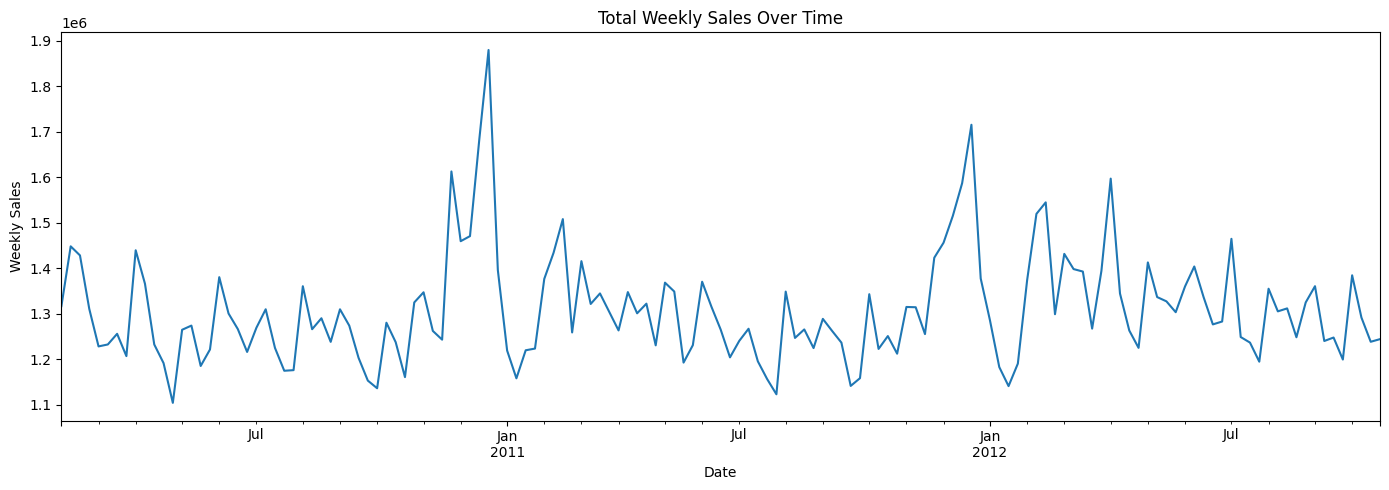

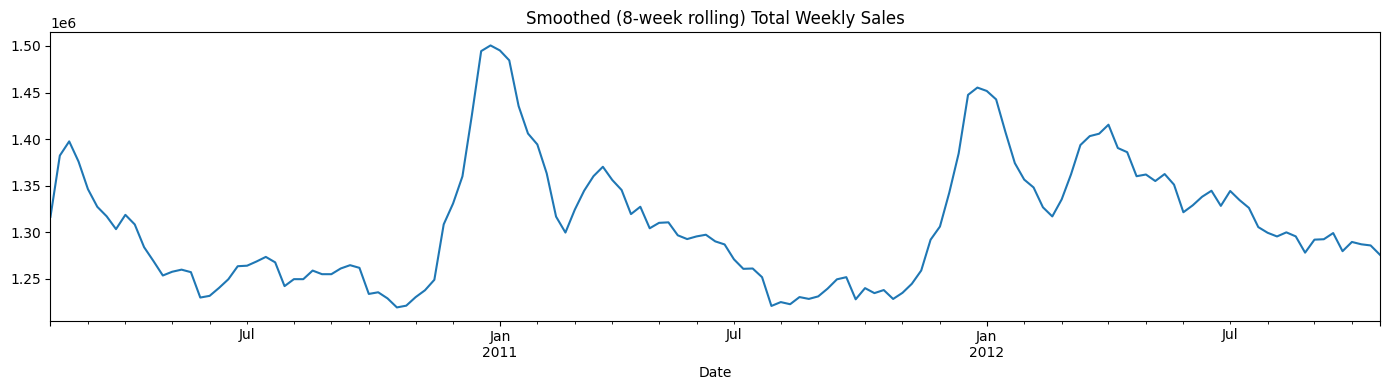

In [12]:
# Cell 6 — Sales over time (total)
if 'Date' in df.columns and 'Weekly_Sales' in df.columns:
    plt.figure(figsize=(14,5))
    ts = df.groupby('Date')['Weekly_Sales'].sum()
    ts.plot()
    plt.title('Total Weekly Sales Over Time')
    plt.ylabel('Weekly Sales')
    plt.tight_layout()
    plt.savefig('eda_outputs/sales_over_time.png')
    plt.show()

    # Rolling sum to smooth
    plt.figure(figsize=(14,4))
    ts.rolling(window=8, min_periods=1).mean().plot()
    plt.title('Smoothed (8-week rolling) Total Weekly Sales')
    plt.tight_layout()
    plt.savefig('eda_outputs/sales_over_time_smoothed.png')
    plt.show()
else:
    print("Skipping time-series plots (Date or Weekly_Sales not found).")


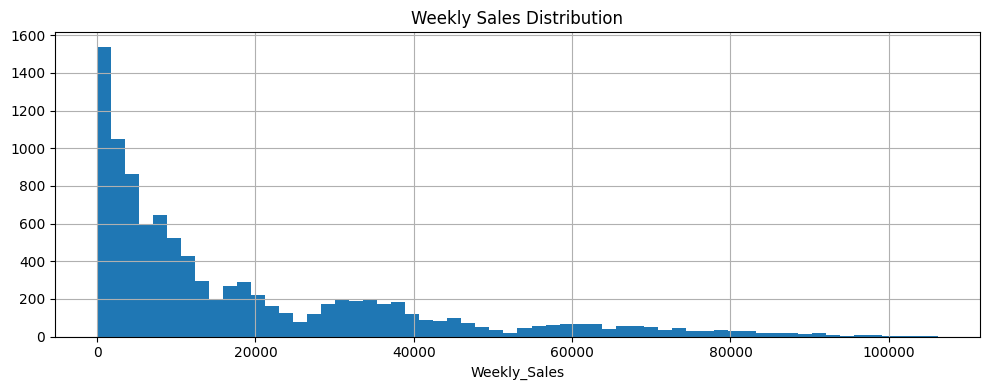

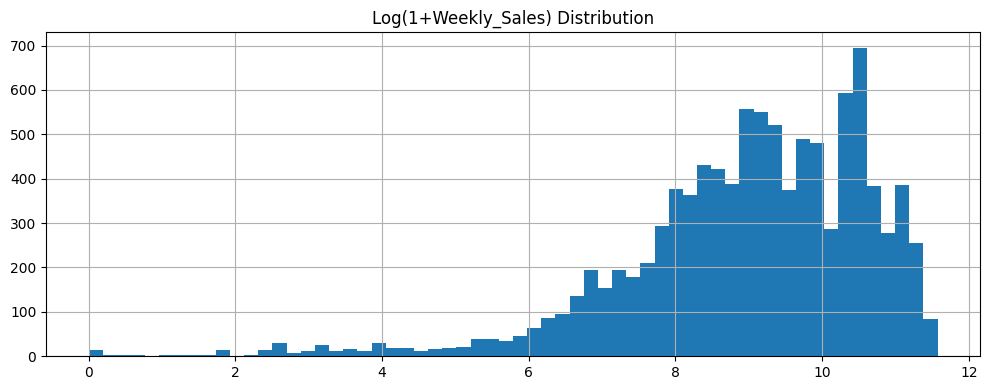

Top 10 rows by Weekly_Sales:


,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,IsHoliday,Month,Week,Year,Day,DayOfWeek,Weekly_Sales_Rolling4,Sales_vs_StoreMean,Type_B,Type_C
9199,1,92,2010-12-31,106205.58,48.43,2.943,0.00,0.00,0.00,0.00,0.00,211.404932,7.838,151315,1,12,52,2010,31,4,NaN,5.701905,0,0
9488,1,95,2010-11-26,106015.41,64.52,2.735,0.00,0.00,0.00,0.00,0.00,211.748433,7.838,151315,1,11,47,2010,26,4,NaN,5.691695,0,0
9487,1,95,2010-10-29,105793.40,69.64,2.716,0.00,0.00,0.00,0.00,0.00,211.908844,7.838,151315,0,10,43,2010,29,4,NaN,5.679776,0,0
5128,1,38,2010-06-11,105539.53,80.43,2.668,0.00,0.00,0.00,0.00,0.00,211.456095,7.808,151315,0,6,23,2010,11,4,92471.8850,5.666147,0,0
8961,1,90,2010-12-24,103958.12,52.33,2.886,0.00,0.00,0.00,0.00,0.00,211.405122,7.838,151315,0,12,51,2010,24,4,85366.3675,5.581245,0,0
9491,1,95,2011-01-21,103724.16,44.04,3.016,0.00,0.00,0.00,0.00,0.00,211.827234,7.742,151315,0,1,3,2011,21,4,101062.7075,5.568684,0,0
9486,1,95,2010-02-26,103652.58,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,151315,0,2,8,2010,26,4,NaN,5.564841,0,0
9493,1,95,2011-12-02,102798.99,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,151315,0,12,48,2011,2,4,99810.8600,5.519014,0,0
9495,1,95,2012-01-27,102202.04,54.26,3.290,1164.46,1082.74,44.00,11.00,1222.19,220.078852,7.348,151315,0,1,4,2012,27,4,99350.8200,5.486965,0,0
5120,1,38,2010-04-02,101566.87,62.27,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,151315,0,4,13,2010,2,4,91690.8375,5.452865,0,0


In [13]:
# Cell 7 — distribution and outliers
if 'Weekly_Sales' in df.columns:
    plt.figure(figsize=(10,4))
    df['Weekly_Sales'].hist(bins=60)
    plt.title('Weekly Sales Distribution')
    plt.xlabel('Weekly_Sales')
    plt.tight_layout()
    plt.savefig('eda_outputs/weekly_sales_hist.png')
    plt.show()

    # log transform view (handles skew)
    plt.figure(figsize=(10,4))
    np.log1p(df['Weekly_Sales']).hist(bins=60)
    plt.title('Log(1+Weekly_Sales) Distribution')
    plt.tight_layout()
    plt.savefig('eda_outputs/weekly_sales_log_hist.png')
    plt.show()

    # show top outlier rows
    print("Top 10 rows by Weekly_Sales:")
    display(df.sort_values('Weekly_Sales', ascending=False).head(10))



=== Store value counts (top 20) ===


Store
1    9941
2      59
Name: count, dtype: int64

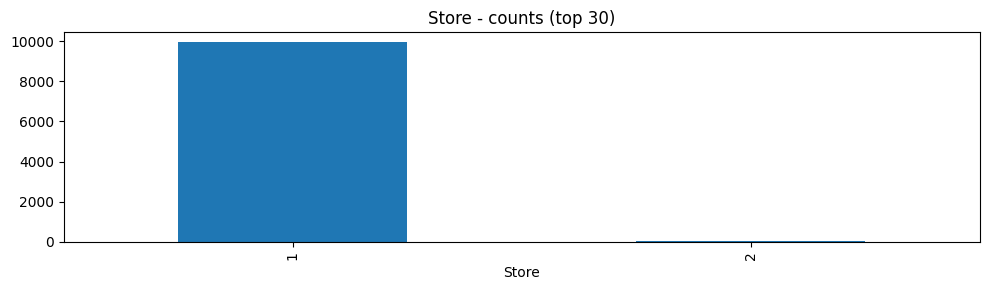


=== Dept value counts (top 20) ===


Dept
1     202
2     143
3     143
4     143
5     143
9     143
8     143
11    143
10    143
12    143
13    143
16    143
14    143
98    143
94    143
17    143
19    143
21    143
20    143
22    143
Name: count, dtype: int64

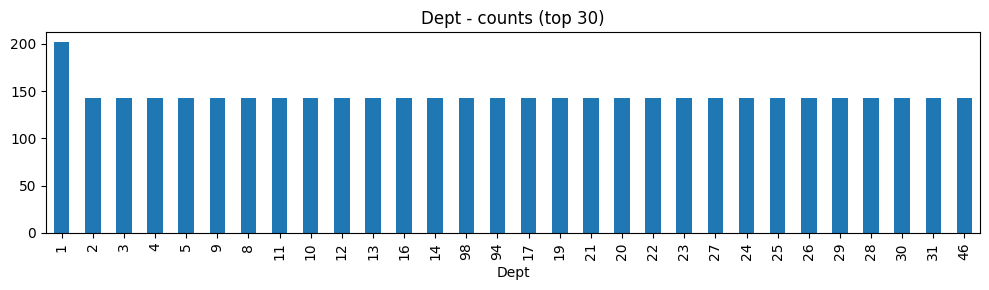


=== Type_B value counts (top 20) ===


Type_B
0    10000
Name: count, dtype: int64

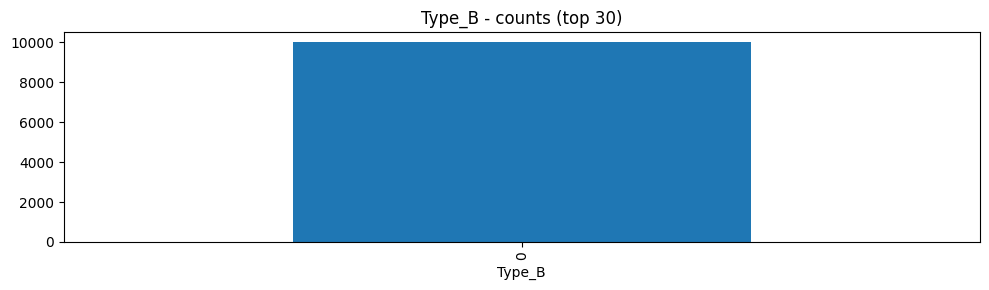


=== Type_C value counts (top 20) ===


Type_C
0    10000
Name: count, dtype: int64

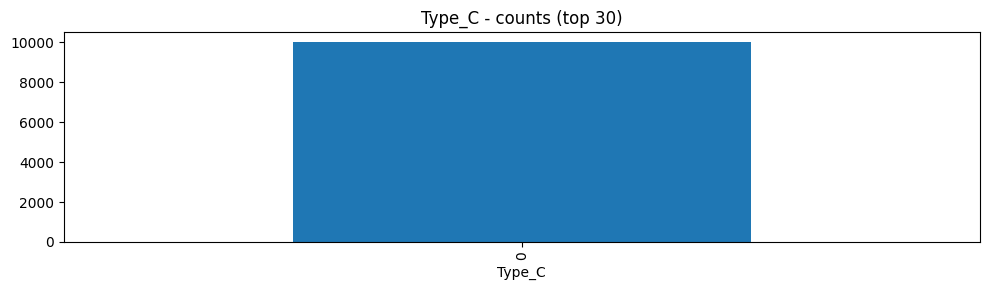


=== IsHoliday value counts (top 20) ===


IsHoliday
0    9291
1     709
Name: count, dtype: int64

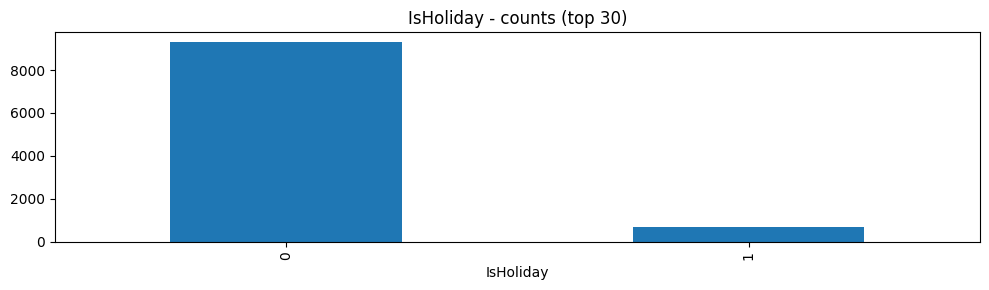

In [14]:
# Cell 8 — categorical summaries & charts
cat_cols = [c for c in ['Store','Dept','Type_B','Type_C','IsHoliday','Type'] if c in df.columns]
for c in cat_cols:
    print(f"\n=== {c} value counts (top 20) ===")
    display(df[c].value_counts().head(20))
    # bar chart (top 30)
    plt.figure(figsize=(10,3))
    df[c].value_counts().head(30).plot(kind='bar')
    plt.title(f'{c} - counts (top 30)')
    plt.tight_layout()
    plt.savefig(f"eda_outputs/{c}_value_counts.png")
    plt.show()


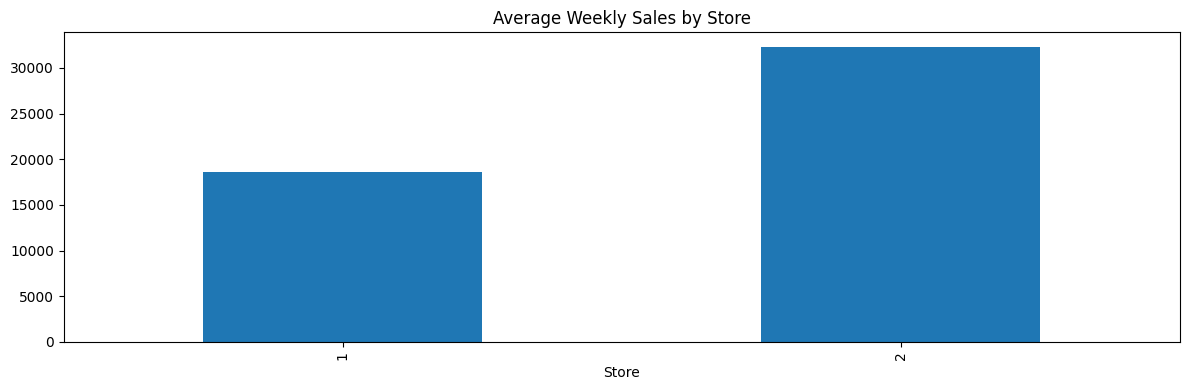

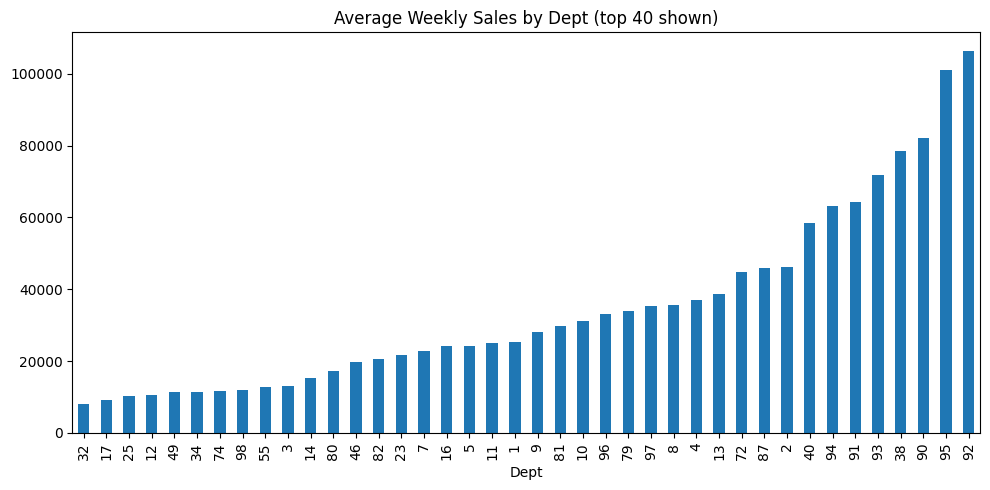

Mean Weekly_Sales by IsHoliday:


IsHoliday
0    18616.250498
1    19895.352736
Name: Weekly_Sales, dtype: float64

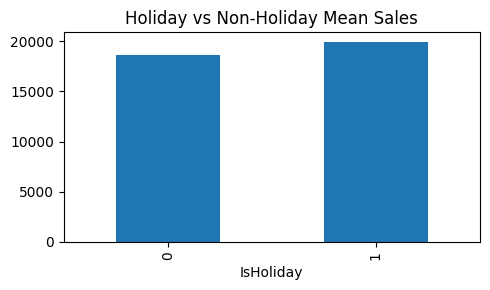

In [15]:
# Cell 9 — grouped statistics
if 'Weekly_Sales' in df.columns:
    if 'Store' in df.columns:
        store_mean = df.groupby('Store')['Weekly_Sales'].mean().sort_values()
        plt.figure(figsize=(12,4))
        store_mean.plot(kind='bar')
        plt.title('Average Weekly Sales by Store')
        plt.tight_layout()
        plt.savefig('eda_outputs/avg_sales_by_store.png')
        plt.show()

    if 'Dept' in df.columns:
        dept_mean = df.groupby('Dept')['Weekly_Sales'].mean().sort_values()
        plt.figure(figsize=(10,5))
        dept_mean.tail(40).plot(kind='bar')  # show top depts
        plt.title('Average Weekly Sales by Dept (top 40 shown)')
        plt.tight_layout()
        plt.savefig('eda_outputs/avg_sales_by_dept.png')
        plt.show()

    if 'IsHoliday' in df.columns:
        print("Mean Weekly_Sales by IsHoliday:")
        display(df.groupby('IsHoliday')['Weekly_Sales'].mean())
        plt.figure(figsize=(5,3))
        df.groupby('IsHoliday')['Weekly_Sales'].mean().plot(kind='bar')
        plt.title('Holiday vs Non-Holiday Mean Sales')
        plt.tight_layout()
        plt.savefig('eda_outputs/holiday_vs_nonholiday_sales.png')
        plt.show()


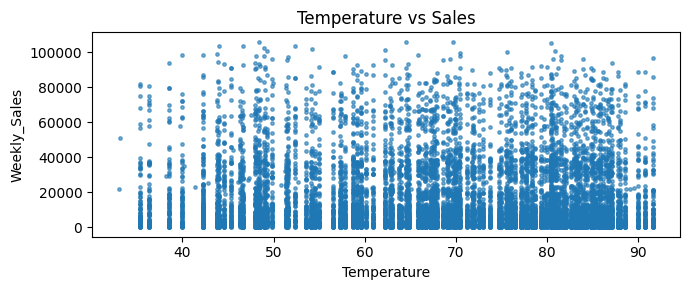

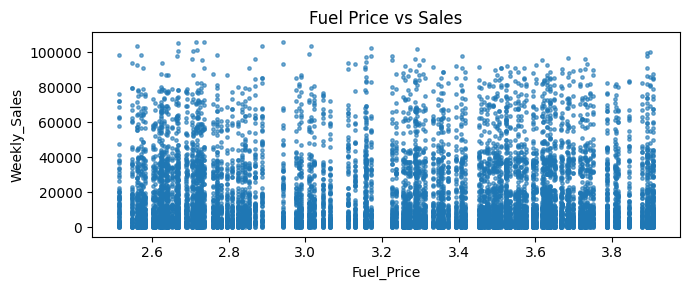

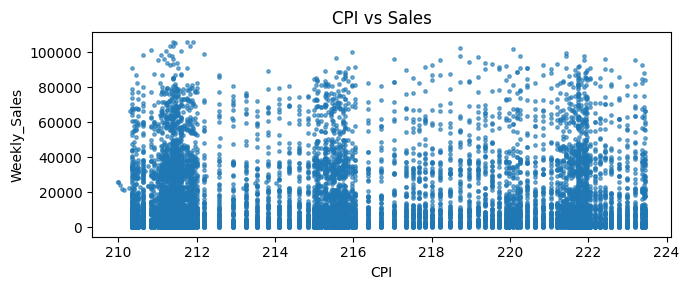

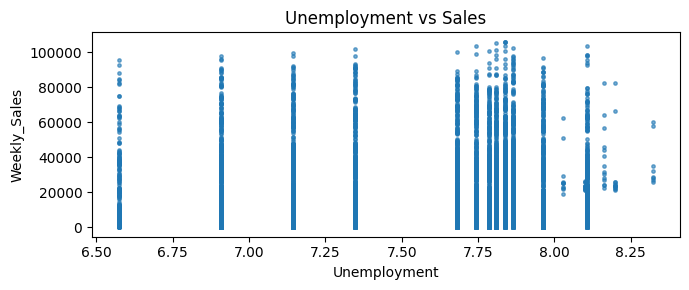

In [16]:
# Cell 10 — numeric relationships scatter plots
pairs = []
if all(c in df.columns for c in ['Temperature','Weekly_Sales']): pairs.append(('Temperature','Temperature vs Sales'))
if all(c in df.columns for c in ['Fuel_Price','Weekly_Sales']): pairs.append(('Fuel_Price','Fuel Price vs Sales'))
if all(c in df.columns for c in ['CPI','Weekly_Sales']): pairs.append(('CPI','CPI vs Sales'))
if all(c in df.columns for c in ['Unemployment','Weekly_Sales']): pairs.append(('Unemployment','Unemployment vs Sales'))

for col, title in pairs:
    plt.figure(figsize=(7,3))
    plt.scatter(df[col], df['Weekly_Sales'], s=6, alpha=0.6)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Weekly_Sales')
    plt.tight_layout()
    fname = f"eda_outputs/scatter_{col}_vs_sales.png"
    plt.savefig(fname)
    plt.show()


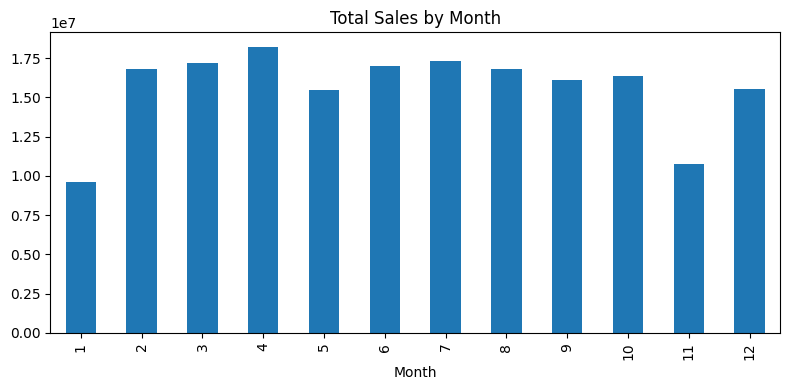

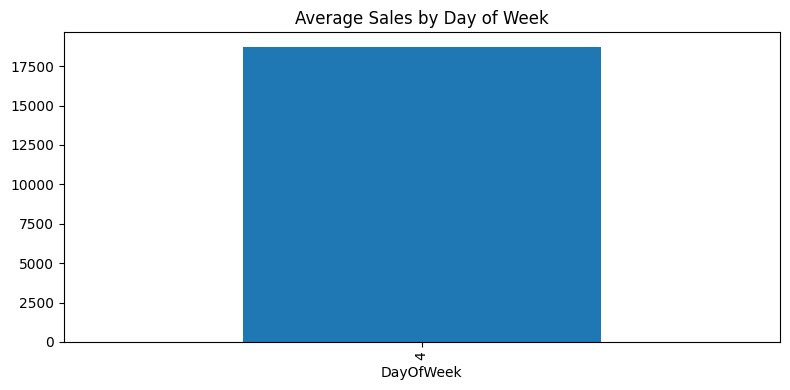

In [17]:
# Cell 11 — seasonality by month and day of week
if 'Date' in df.columns:
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Mon,6=Sun
    # Monthly totals
    plt.figure(figsize=(8,4))
    df.groupby('Month')['Weekly_Sales'].sum().plot(kind='bar')
    plt.title('Total Sales by Month')
    plt.tight_layout()
    plt.savefig('eda_outputs/sales_by_month.png')
    plt.show()
    # Day of week
    plt.figure(figsize=(8,4))
    df.groupby('DayOfWeek')['Weekly_Sales'].mean().plot(kind='bar')
    plt.title('Average Sales by Day of Week')
    plt.tight_layout()
    plt.savefig('eda_outputs/sales_by_dayofweek.png')
    plt.show()


Numeric columns used for correlation: ['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'IsHoliday', 'Month', 'Week', 'Year', 'Day', 'DayOfWeek', 'Weekly_Sales_Rolling4', 'Sales_vs_StoreMean', 'Type_B', 'Type_C']

Top correlations with Weekly_Sales:
 Weekly_Sales             1.000000
Sales_vs_StoreMean       0.999713
Weekly_Sales_Rolling4    0.984194
Dept                     0.241454
Size                     0.049878
Store                    0.049878
Temperature              0.022705
MarkDown1                0.020738
Day                      0.020298
MarkDown5                0.018493
IsHoliday                0.015650
MarkDown4                0.015209
CPI                      0.014320
Month                    0.011884
Year                     0.010583
Name: Weekly_Sales, dtype: float64


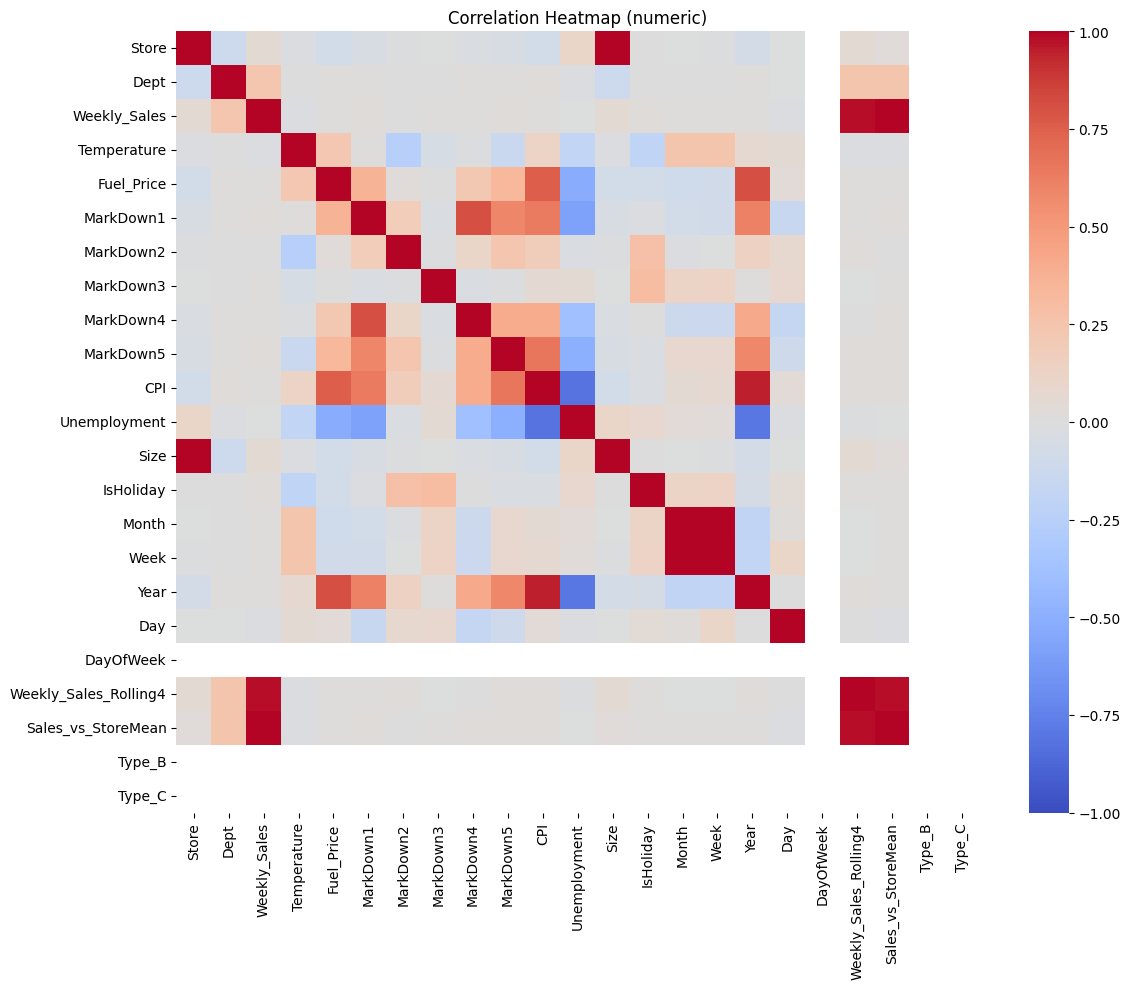

In [18]:
# Cell 12 — correlation matrix
num = df.select_dtypes(include=[np.number]).copy()
if 'Weekly_Sales' not in num.columns and 'Weekly_Sales' in df.columns:
    num['Weekly_Sales'] = df['Weekly_Sales']

print("Numeric columns used for correlation:", num.columns.tolist())
corr = num.corr()

# Print strongest correlations with Weekly_Sales (absolute)
if 'Weekly_Sales' in corr.columns:
    corr_with_target = corr['Weekly_Sales'].abs().sort_values(ascending=False)
    print("\nTop correlations with Weekly_Sales:\n", corr_with_target.head(15))

# Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap (numeric)')
plt.tight_layout()
plt.savefig('eda_outputs/corr_heatmap.png')
plt.show()


Creating pairplot for: ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales_Rolling4']


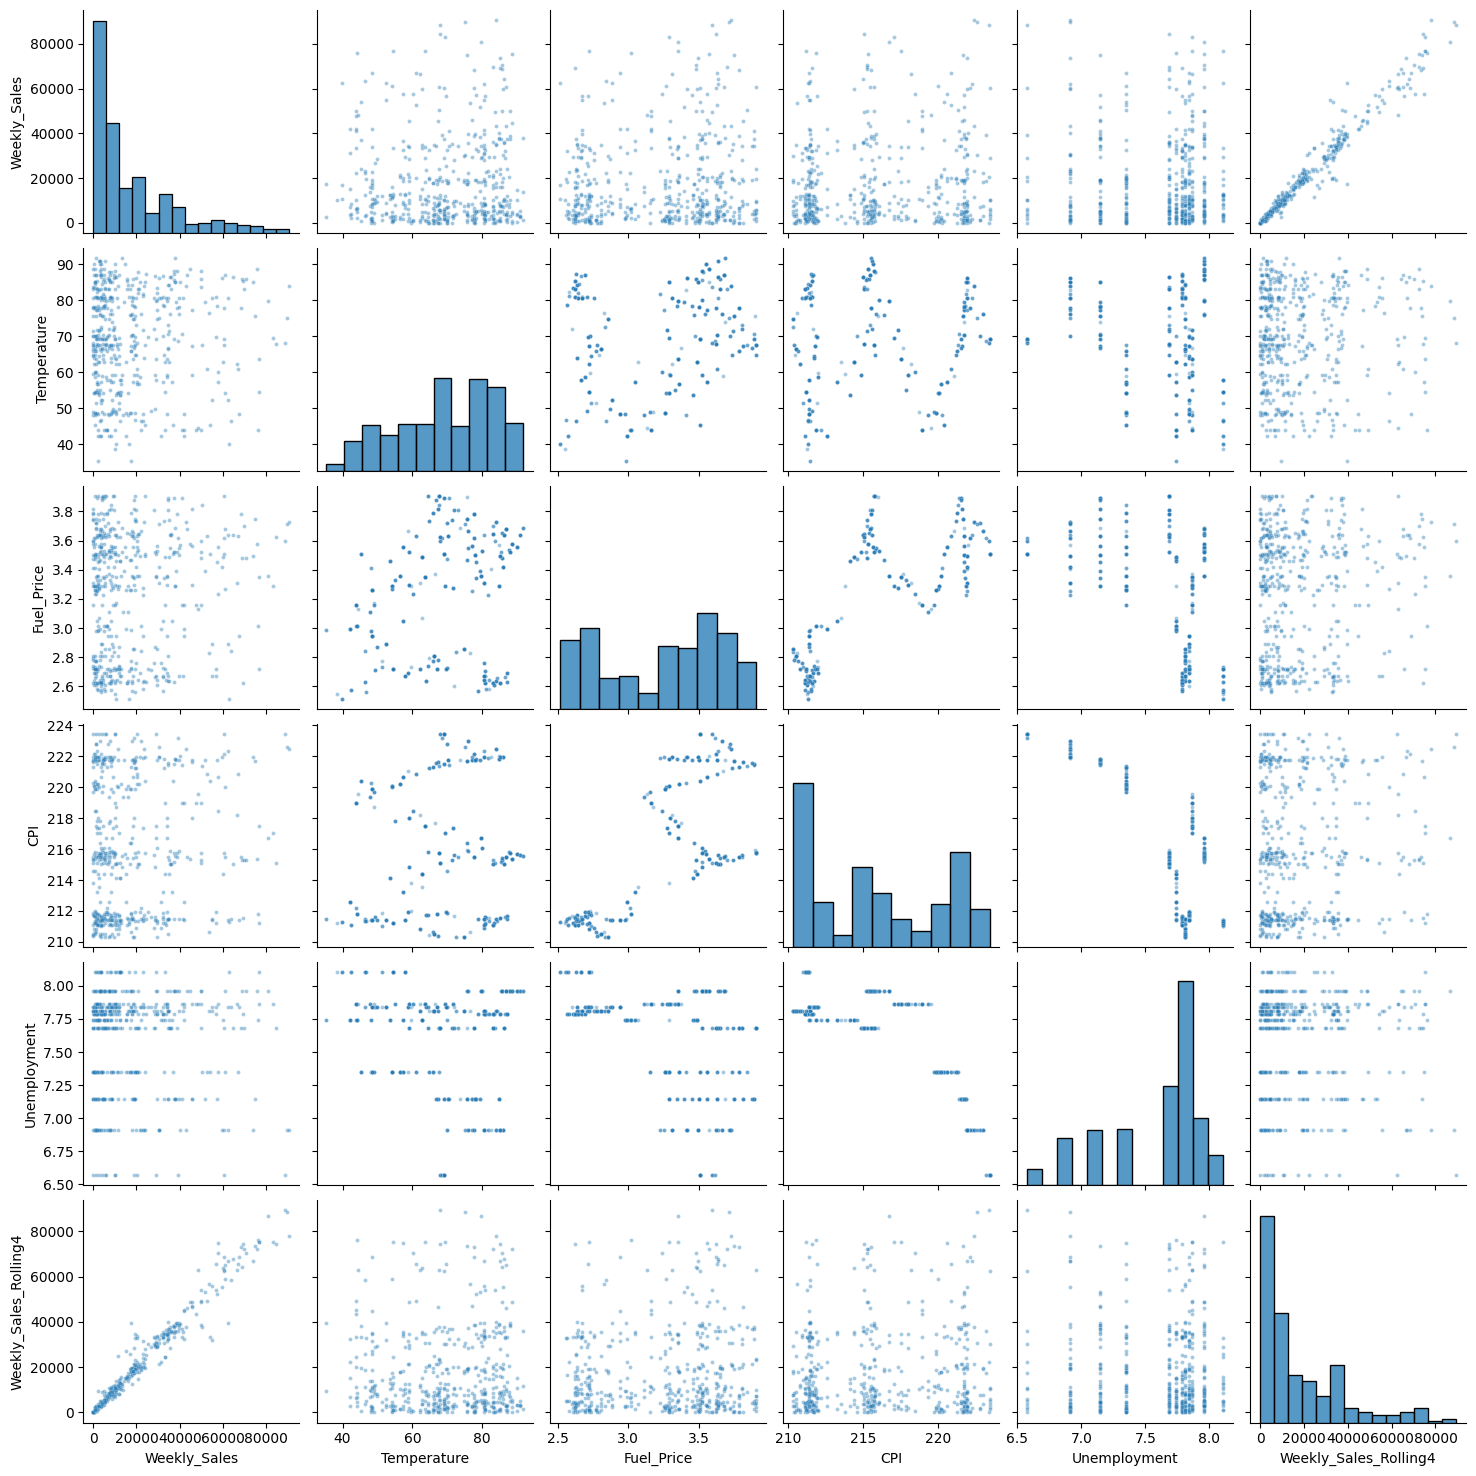

In [19]:
# Cell 13 — pairplot / pairwise scatter (optional; may be slow)
sample_for_pairs = df.sample(n=min(500, len(df)), random_state=42)  # sample to keep it fast
pair_cols = [c for c in ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales_Rolling4'] if c in df.columns]
if len(pair_cols) >= 2:
    print("Creating pairplot for:", pair_cols)
    sns.pairplot(sample_for_pairs[pair_cols], plot_kws={'s':8, 'alpha':0.4})
    plt.savefig('eda_outputs/pairplot_sample.png')
    plt.show()
else:
    print("Not enough numeric columns available for pairplot.")


In [20]:
# Cell 14 — save cleaned dataset and key outputs
# After EDA you may want to save a cleaned version for modeling:
CLEANED_PATH = Path("data/cleaned_engineered_data_cleaned.csv")
df.to_csv(CLEANED_PATH, index=False)
print("Saved cleaned dataset to:", CLEANED_PATH)

# Save (already saved) summary CSVs / lists if needed
pd.DataFrame(missing).to_csv("eda_outputs/missing_columns.csv")


Saved cleaned dataset to: data\cleaned_engineered_data_cleaned.csv


In [24]:
# Cell 15 — preprocessing for modeling (numeric + categorical)
from sklearn.model_selection import train_test_split

print("=== Preprocessing for modeling ===")

# 1️⃣ Date features (if not already created)
if 'Date' in df.columns:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Mon,6=Sun
    df = df.drop('Date', axis=1)  # drop original Date for modeling

# 2️⃣ One-hot encode categorical columns
cat_cols = [c for c in ['Store','Dept','Type_B','Type_C','IsHoliday','Type'] if c in df.columns]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 3️⃣ Separate features and target
target_col = 'Weekly_Sales'
X = df.drop(target_col, axis=1)
y = df[target_col]

# 4️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Preprocessing complete.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


=== Preprocessing for modeling ===
Preprocessing complete.
X_train shape: (8000, 95)
X_test shape: (2000, 95)
y_train shape: (8000,)
y_test shape: (2000,)
